In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as scs
import warnings
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_white, het_breuschpagan, het_goldfeldquandt

warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


https://www.fireblazeaischool.in/blogs/assumptions-of-linear-regression/

https://www.statsmodels.org/0.6.1/examples/notebooks/generated/regression_diagnostics.html

https://www.listendata.com/2018/01/linear-regression-in-python.html

https://www.statology.org/weighted-least-squares-in-r/

https://jbhender.github.io/Stats506/F17/Projects/Abalone_WLS.html

In [ ]:
def diagnostico_residuos(resids):
  # create placeholder subplots
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,6))
  r = resids
  resids = (r - np.nanmean(r)) / np.nanstd(r)
  resids_nonmissing = resids[~(np.isnan(resids))]
  # residuals over time
  sns.scatterplot(x=np.arange(1, len(resids)+1), y=resids, ax=ax1)
  ax1.axhline(0, color='r', linestyle='--')  
  ax1.set_title('Residuos Estandarizados')
  # distribution of residuals
  x_lim = (-1.96 * 2, 1.96 * 2)
  r_range = np.linspace(x_lim[0], x_lim[1])
  norm_pdf = scs.norm.pdf(r_range)
  sns.distplot(resids_nonmissing, hist=True, kde=True,norm_hist=True, ax=ax2)
  ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
  ax2.set_title('Distribución de residuales estandarizados')
  ax2.set_xlim(x_lim)
  ax2.legend()
  # Q-Q plot
  qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
  ax3.set_title('Q-Q plot')
  # Hide last plot
  ax4.axis('off')
  fig.tight_layout(pad=2)
  return fig

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/educ.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       50 non-null     float64
 1   x1      50 non-null     float64
 2   x2      50 non-null     float64
dtypes: float64(3)
memory usage: 1.3 KB


x1 = educación

x2 = preferencias politicas

y = autonomía fiscal

**PUNTO A**

In [ ]:
X = df[['x1','x2']]
X = sm.add_constant(X)
y = df.y

In [ ]:
modelo = sm.OLS(y, X)
resultados = modelo.fit()
print(resultados.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9258
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.403
Time:                        17:39:14   Log-Likelihood:                -162.04
No. Observations:                  50   AIC:                             330.1
Df Residuals:                      47   BIC:                             335.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1904      0.914      0.208      0.8

In [ ]:
# DATOS PARA MINIMOS CUADRADOS PONDERADOS (WLS)
# fitted values (need a constant term for intercept)
model_fitted_y = resultados.fittedvalues
# model residuals
model_residuals = resultados.resid
# absolute residuals
model_abs_resid = np.abs(model_residuals)

Text(0, 0.5, 'residuos absolutos (|e|)')

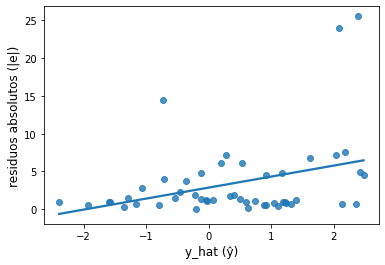

In [ ]:
sns.regplot(resultados.fittedvalues, abs(resultados.resid), ci=False)
plt.xlabel('y_hat (ŷ)', fontsize=12)
plt.ylabel('residuos absolutos (|e|)', fontsize=12)

Text(0, 0.5, 'residuales (e)')

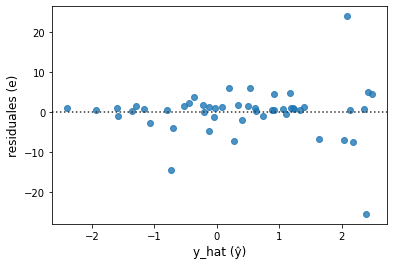

In [ ]:
sns.residplot(resultados.fittedvalues, resultados.resid)
plt.xlabel('y_hat (ŷ)', fontsize=12)
plt.ylabel('residuales (e)', fontsize=12)

**PUNTO B**

In [ ]:
modelo_robust = sm.OLS(y, X)
resultados_robust = modelo_robust.fit(cov_type='HC1')
print(resultados_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                     2.363
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.105
Time:                        17:59:21   Log-Likelihood:                -162.04
No. Observations:                  50   AIC:                             330.1
Df Residuals:                      47   BIC:                             335.8
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1904      0.747      0.255      0.7

In [ ]:
# Comparisson between SE of OLS and OLS with robust standard errors.
pd.concat([resultados.bse, resultados_robust.bse], axis=1).rename({0:'OLS se',1:'OLS - rob. se'}, axis=1).applymap(lambda x: np.round(x, 4))

,OLS se,OLS - rob. se
const,0.9144,0.7470
x1,0.9826,0.5481
x2,0.4399,1.1034


Se puede observar que el error estandar del estimador x1 disminuyó notablemente a tal punto que la educación pasó de ser una variable estadísticamente no significativa a una estadísticamente significativa. Por otro lado, el error estándar de las preferencias políticas aumentó, indicando en ambos modelos que la variable no es estadísticamente siginifactiva para explicar la autonomía fiscal. 

La heterocedasticidad en el modelo de regresión afecta principalmente la inferencia estadística.

**PUNTO C**

H0 = Hay homocedasticidad en el modelo de regresión

H1 = Hay heterocedasticidad en el modelo de regresión

In [ ]:
hw_test = het_white(resultados.resid, resultados.model.exog)

dict(list(zip(['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value'], hw_test))[2:])

{'F-Statistic': 31.74641282710611, 'F-Test p-value': 1.5067434695842272e-13}

In [ ]:
bp_test = het_breuschpagan(resultados.resid, resultados.model.exog)

dict(list(zip(['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value'], bp_test))[2:])

{'F-Statistic': 9.329238516126505, 'F-Test p-value': 0.0003872271019027869}

Luego de realizados los test de White y de Breush y Pagan para corroborar si hay heteroscedasticidad en nuestro modelo de regresión, podemos verificar que sus p-values son 0.00 < 0.05 y 0.0004 < 0.05 respectivamente. Es decir, ambos tests indican que rechazamos la hipótesis nula de que hay homocedasticidad en el modelo de regresión (p < 0.05).

En consecuencia procederemos a trabajar con OLS con errores estándar robustos (White-Huber) para que nuestras inferencias sobre las variables exógenas del modelo sean confiables.

**PUNTO D**

HO = La varianza de los residuales en ambas submuestras son iguales.

H1 = La varianza de los residuales en ambas submuestras no son iguales.

In [ ]:
# X1
gd_x1 = df.iloc[:, :2].sort_values(by='x1')
gd_x1_y = gd_x1.y
gd_x1_X = sm.add_constant(gd_x1.x1)

# X2
gd_x2 = df[['y','x2']].sort_values(by='x2')
gd_x2_y = gd_x2.y
gd_x2_X = sm.add_constant(gd_x2.x2)

In [ ]:
# Con X1
gq_test_x1 = het_goldfeldquandt(gd_x1_y, gd_x1_X, drop=10, split=20)

dict(zip(['F-Statistic', 'F-Test p-value','Ordering'], [np.round(i,4) if type(i) != str else i for i in gq_test_x1]))

{'F-Statistic': 0.411, 'F-Test p-value': 0.9665, 'Ordering': 'increasing'}

In [ ]:
# Con X2
gq_test_x2 = het_goldfeldquandt(gd_x2_y, gd_x2_X, drop=10, split=20)

dict(zip(['F-Statistic', 'F-Test p-value','Ordering'], [np.round(i,4) if type(i) != str else i for i in gq_test_x2]))

{'F-Statistic': 4.3372, 'F-Test p-value': 0.0016, 'Ordering': 'increasing'}

**PUNTO E**

Para la regresión de mínimos cuadrados ponderados corrí una regresión OLS sobre los residuales absolutos (provenientes de una OLS de la var. dependiente e independientes originales, punto A) contra las variables independientes originales.

Los valores estimados de esta regresión son una estimación del error de cada observación que luego serán utilizados para cálcular la inversa de la varianza (1/ (σ i) ^ 2) utilizada luego como peso en WLS.

In [ ]:
## Compute the weight and add it to the column named "weight_2"
model_temp = sm.OLS(model_abs_resid, resultados.model.exog).fit()  
weight_2 = model_temp.fittedvalues**(-2)

mod_wls = sm.WLS(y, resultados.model.exog, weights=weight_2)
mod_res = mod_wls.fit()
print(mod_res.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            WLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.282
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.287
Time:                        18:35:08   Log-Likelihood:                -186.83
No. Observations:                  50   AIC:                             379.7
Df Residuals:                      47   BIC:                             385.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4813      1.817      0.815      0.4

In [ ]:
pd.concat([resultados.bse, resultados_robust.bse, mod_res.bse], axis=1).rename({0:'OLS se',1:'OLS robust se', 2:'WLS se'}, axis=1).applymap(lambda x: np.round(x, 4))

,OLS se,OLS robust se,WLS se
const,0.9144,0.7470,1.8169
x1,0.9826,0.5481,0.9716
x2,0.4399,1.1034,0.7451


In [ ]:
hw_test_2 = het_white(mod_res.resid, mod_res.model.exog)

dict(list(zip(['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value'], hw_test_2))[2:])

{'F-Statistic': 128.26016834262674, 'F-Test p-value': 4.479391855012567e-25}